<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning-UAS/blob/main/Chapter_3_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Persiapan Awal

In [1]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt
from pathlib import Path

# Set ukuran default tampilan plot
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Direktori penyimpanan gambar
IMAGES_PATH = Path("images/classification")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Fungsi simpan gambar
def save_fig(fig_id, tight=True, ext="png", dpi=300):
    path = IMAGES_PATH / f"{fig_id}.{ext}"
    if tight:
        plt.tight_layout()
    plt.savefig(path, format=ext, dpi=dpi)

## Memuat dan Visualisasi MNIST

Gambar Satu Digit


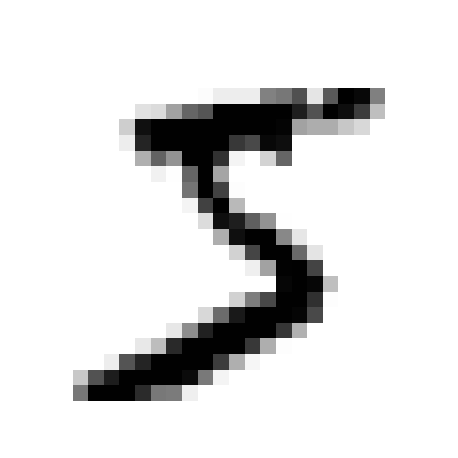


Gambar 100 Digit Pertama


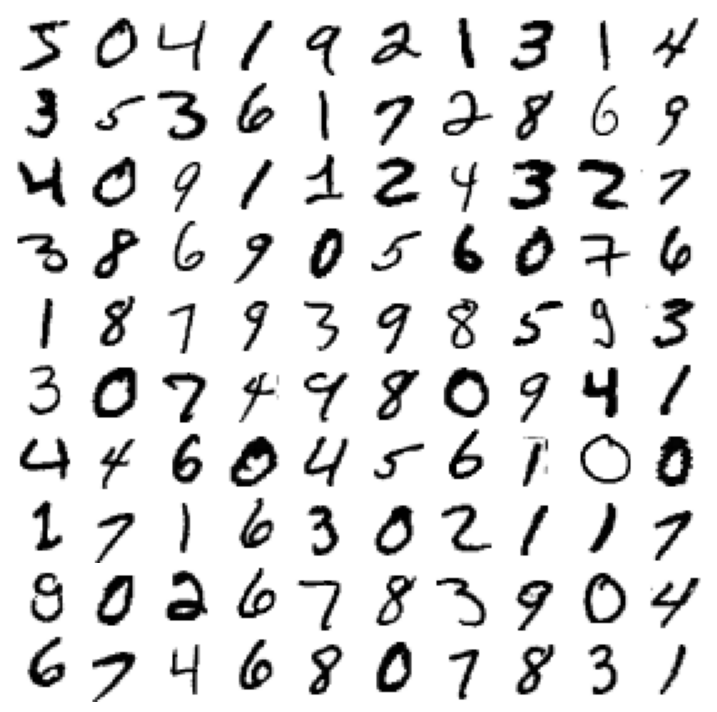

In [2]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Load MNIST
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target

# Fungsi plot digit
def plot_digit(image_data):
    plt.imshow(image_data.reshape(28, 28), cmap="binary")
    plt.axis("off")

# Direktori simpan gambar
IMAGES_PATH = Path("images/classification")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight=True, ext="png", dpi=300):
    path = IMAGES_PATH / f"{fig_id}.{ext}"
    if tight:
        plt.tight_layout()
    plt.savefig(path, format=ext, dpi=dpi)

# Plot 1 digit
print('Gambar Satu Digit')
plot_digit(X[0])
save_fig("some_digit_plot")
plt.show()

# Plot 100 digit pertama
print('\nGambar 100 Digit Pertama')
plt.figure(figsize=(9, 9))
for idx in range(100):
    plt.subplot(10, 10, idx + 1)
    plot_digit(X[idx])
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight=False)
plt.show()

# Bagi data menjadi train dan test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Membagi Data Traning dan Klsifikasi Biner

In [3]:
from sklearn.linear_model import SGDClassifier

print("Dataset MNIST sudah terurut, 60.000 pertama untuk training, 10.000 sisanya untuk testing\n")

# Split data
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print(f"Data training: {X_train.shape[0]} sampel")
print(f"Data testing: {X_test.shape[0]} sampel")

# Klasifikasi apakah gambar adalah angka '5'
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

# Training model SGD
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Prediksi 1 sampel
prediction = sgd_clf.predict([X[0]])
print(f"\nApakah gambar pertama adalah angka 5? {'Ya' if prediction[0] else 'Bukan'}")

Dataset MNIST sudah terurut, 60.000 pertama untuk training, 10.000 sisanya untuk testing

Data training: 60000 sampel
Data testing: 10000 sampel

Apakah gambar pertama adalah angka 5? Ya


# **Performance**

## Cross Validation

In [4]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier

# Inisialisasi classifier dan target biner (angka 5)
sgd_clf = SGDClassifier(random_state=42)
y_train_5 = (y_train == '5')

# Evaluasi akurasi dengan cross-validation (3-fold)
cv_scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print("Akurasi CV (SGDClassifier):", cv_scores)

# Implementasi manual StratifiedKFold
print("\nEvaluasi manual StratifiedKFold:")
skfolds = StratifiedKFold(n_splits=3)
for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds, y_train_folds = X_train[train_idx], y_train_5[train_idx]
    X_test_fold, y_test_fold = X_train[test_idx], y_train_5[test_idx]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    acc = np.mean(y_pred == y_test_fold)
    print(f"Akurasi fold: {acc:.4f}")

# Dummy classifier sebagai baseline (selalu prediksi mayoritas)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train_5)

print("\nContoh prediksi DummyClassifier:", dummy_clf.predict(X_train[:10]))
dummy_scores = cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print("Akurasi CV (DummyClassifier):", dummy_scores)

Akurasi CV (SGDClassifier): [0.95035 0.96035 0.9604 ]

Evaluasi manual StratifiedKFold:
Akurasi fold: 0.9504
Akurasi fold: 0.9604
Akurasi fold: 0.9604

Contoh prediksi DummyClassifier: [False False False False False False False False False False]
Akurasi CV (DummyClassifier): [0.90965 0.90965 0.90965]


## Confusion Matriks

Confusion Matrix:
 [[53892   687]
 [ 1891  3530]]


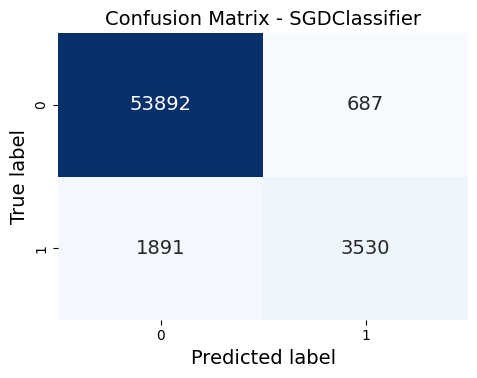


Confusion Matrix (Prediksi Sempurna):
 [[54579     0]
 [    0  5421]]


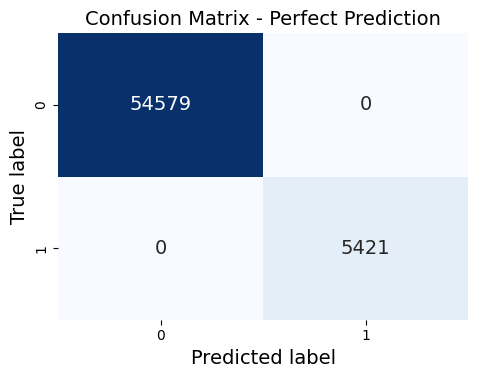

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

# Fungsi untuk plot confusion matrix
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

# Prediksi menggunakan cross-validation (3-fold)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Confusion matrix dari prediksi
cm = confusion_matrix(y_train_5, y_train_pred)
print("Confusion Matrix:\n", cm)
plot_confusion_matrix(cm, title="Confusion Matrix - SGDClassifier")

# Simulasi prediksi sempurna (untuk perbandingan)
y_train_perfect = y_train_5  # asumsi semua prediksi benar
cm_perfect = confusion_matrix(y_train_5, y_train_perfect)
print("\nConfusion Matrix (Prediksi Sempurna):\n", cm_perfect)
plot_confusion_matrix(cm_perfect, title="Confusion Matrix - Perfect Prediction")


## Precision and Recall

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision: TP / (TP + FP)
precision = precision_score(y_train_5, y_train_pred)
print(f"Precision: {precision:.4f}")

# Recall: TP / (TP + FN)
recall = recall_score(y_train_5, y_train_pred)
print(f"Recall: {recall:.4f}")

# F1 Score: Harmonic mean of precision and recall
f1 = f1_score(y_train_5, y_train_pred)
print(f"F1 Score: {f1:.4f}")

# Versi manual (dari confusion matrix)
tp = cm[1, 1]
fp = cm[0, 1]
fn = cm[1, 0]
precision_manual = tp / (tp + fp)
recall_manual = tp / (tp + fn)
f1_manual = tp / (tp + 0.5 * (fp + fn))

print("\n[Perhitungan Manual]")
print(f"Precision Manual: {precision_manual:.4f}")
print(f"Recall Manual: {recall_manual:.4f}")
print(f"F1 Score Manual: {f1_manual:.4f}")

Precision: 0.8371
Recall: 0.6512
F1 Score: 0.7325

[Perhitungan Manual]
Precision Manual: 0.8371
Recall Manual: 0.6512
F1 Score Manual: 0.7325


## Precisition/Recall Trade-Off

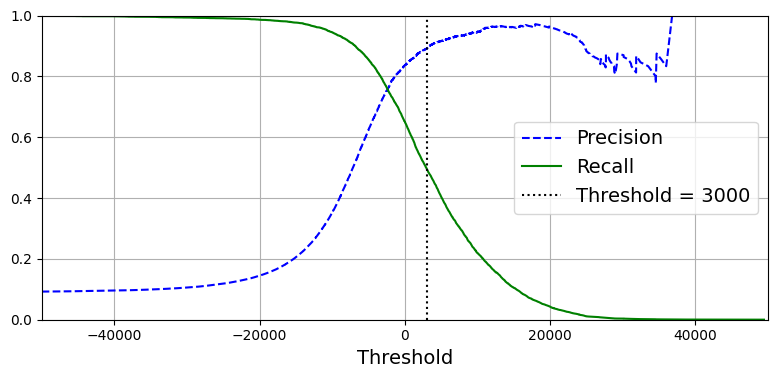

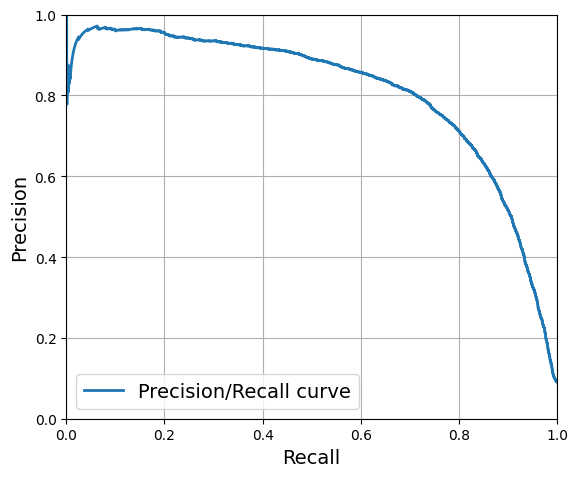

Threshold untuk precision ≥ 90%: 3370.02
Precision @90%: 0.9000
Recall @90%: 0.4800


In [10]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

# Ambil skor keputusan (bukan probabilitas) untuk seluruh data training
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# Hitung precision, recall, dan threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Visualisasi Precision vs Threshold dan Recall vs Threshold
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.vlines(3000, 0, 1, "k", "dotted", label="Threshold = 3000")
plt.xlabel("Threshold")
plt.grid()
plt.axis([-50000, 50000, 0, 1])
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

# Visualisasi Precision vs Recall
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")
plt.show()

# Threshold untuk mencapai minimal precision 90%
idx_90 = (precisions >= 0.90).argmax()
threshold_90 = thresholds[idx_90]
print(f"Threshold untuk precision ≥ 90%: {threshold_90:.2f}")

# Prediksi dengan threshold tersebut
y_train_pred_90 = (y_scores >= threshold_90)

# Evaluasi precision dan recall pada threshold tersebut
precision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90 = recall_score(y_train_5, y_train_pred_90)
print(f"Precision @90%: {precision_90:.4f}")
print(f"Recall @90%: {recall_90:.4f}")

## ROC Curve

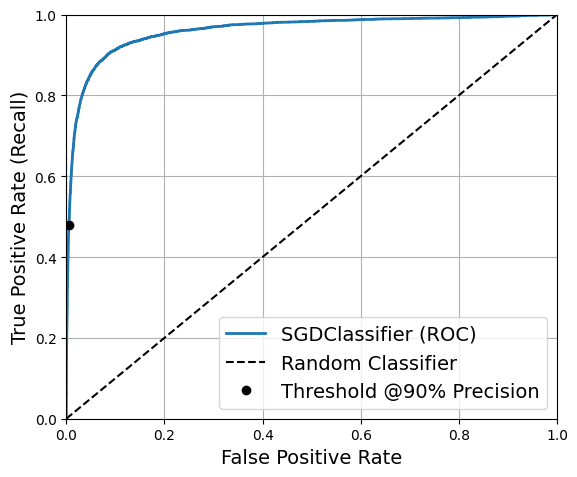


AUC SGDClassifier: 0.9605


In [11]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np

# === ROC Curve untuk SGDClassifier ===
fpr, tpr, thresholds_roc = roc_curve(y_train_5, y_scores)

# Ambil threshold untuk precision ≥ 90% dari sebelumnya
threshold_for_90_precision = threshold_90  # disesuaikan dengan variabel sebelumnya

# Ambil titik ROC yang sesuai dengan threshold tersebut
idx_90 = (thresholds_roc <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_90], fpr[idx_90]

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label="SGDClassifier (ROC)", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold @90% Precision")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right")
save_fig("roc_curve_plot")
plt.show()

# AUC untuk SGDClassifier
auc_sgd = roc_auc_score(y_train_5, y_scores)
print(f"\nAUC SGDClassifier: {auc_sgd:.4f}")

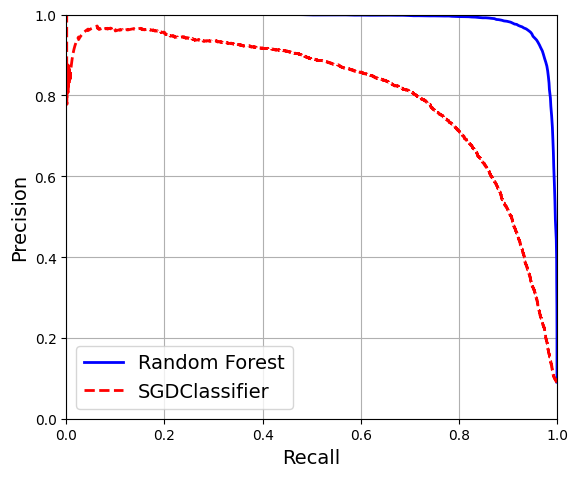

In [12]:
# === Random Forest Classifier ===
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]

# Precision-Recall Curve Random Forest
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

# Bandingkan Precision-Recall Curve: SGD vs Random Forest
plt.figure(figsize=(6, 5))
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "r--", linewidth=2, label="SGDClassifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")
plt.show()

In [13]:
# Evaluasi Random Forest dengan threshold default (0.5)
y_pred_forest = (y_scores_forest >= 0.5)
f1_rf = f1_score(y_train_5, y_pred_forest)
precision_rf = precision_score(y_train_5, y_pred_forest)
recall_rf = recall_score(y_train_5, y_pred_forest)
auc_rf = roc_auc_score(y_train_5, y_scores_forest)

print(f"F1 Score (Random Forest): {f1_rf:.4f}")
print(f"Precision (Random Forest): {precision_rf:.4f}")
print(f"Recall (Random Forest): {recall_rf:.4f}")
print(f"AUC (Random Forest): {auc_rf:.4f}")

F1 Score (Random Forest): 0.9275
Precision (Random Forest): 0.9897
Recall (Random Forest): 0.8725
AUC (Random Forest): 0.9983


## Multiclass Classification

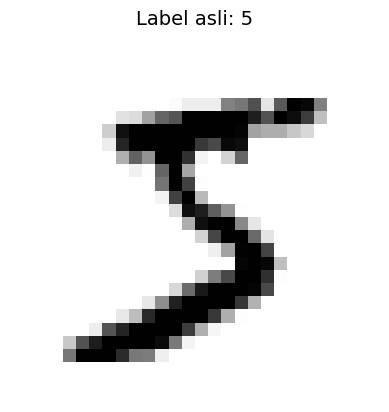

Prediksi SVM: 5 (kelas ke-5)
Skor SVM: [[ 3.79  0.73  6.06  8.3  -0.29  9.3   1.75  2.77  7.21  4.82]]
Label kelas: 5
Prediksi OvR: 5
Jumlah estimator OvR: 10
Prediksi SGD: 3
Skor keputusan SGD: [[-31893.03 -34419.69  -9530.64   1823.73 -22320.15  -1385.8  -26188.91
  -16147.51  -4604.35 -12050.77]]
Akurasi tanpa scaling: 0.8670
Akurasi dengan scaling: 0.8970


In [14]:
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# === Ambil Dataset MNIST ===
mnist = fetch_openml('mnist_784', as_frame=False, parser='pandas')
X, y = mnist.data, mnist.target

# Konversi label ke integer
y = y.astype(np.uint8)

# === Ambil satu sample digit untuk uji prediksi ===
some_digit = X[0]
true_label = y[0]

# Fungsi visualisasi
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plot_digit(some_digit)
plt.title(f"Label asli: {true_label}")
plt.show()

# === Split data MNIST menjadi training dan testing ===
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# === SVM (hanya 2000 sampel pertama untuk efisiensi) ===
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

svm_pred = svm_clf.predict([some_digit])
svm_scores = svm_clf.decision_function([some_digit])
predicted_class = svm_scores.argmax()

print(f"Prediksi SVM: {svm_pred[0]} (kelas ke-{predicted_class})")
print("Skor SVM:", svm_scores.round(2))
print("Label kelas:", svm_clf.classes_[predicted_class])

# === One-vs-Rest dengan SVM ===
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

print(f"Prediksi OvR: {ovr_clf.predict([some_digit])[0]}")
print(f"Jumlah estimator OvR: {len(ovr_clf.estimators_)}")

# === SGDClassifier untuk seluruh data ===
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

sgd_pred = sgd_clf.predict([some_digit])[0]
sgd_score = sgd_clf.decision_function([some_digit])

print(f"Prediksi SGD: {sgd_pred}")
print("Skor keputusan SGD:", sgd_score.round(2))

# === Evaluasi Akurasi Sebelum dan Sesudah Scaling ===
acc_unscaled = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
print(f"Akurasi tanpa scaling: {acc_unscaled.mean():.4f}")

# Scaling fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))

acc_scaled = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print(f"Akurasi dengan scaling: {acc_scaled.mean():.4f}")

# **Ringkasan Proses dan Hasil Prediksi**

## Langkah-Langkah dan Evaluasi Model
Dataset: Menggunakan MNIST, terdiri dari 70.000 gambar digit tulisan tangan berukuran 28×28 piksel.

Sampel Uji: Gambar pertama dalam dataset (disebut some_digit) digunakan untuk pengujian prediksi.
## Support Vector Machine (SVM)
* Model dilatih menggunakan 2.000 sampel pertama untuk efisiensi komputasi.

* Hasil prediksi terhadap some_digit menunjukkan angka 5.

* Skor keputusan (decision score) tertinggi diberikan pada kelas 5.

* Prediksi benar: Sesuai dengan label asli.
## One-vs-Rest (OvR) dengan SVM
* Pendekatan OvR membuat 10 model SVM biner (satu model untuk masing-masing digit 0–9).

* some_digit kembali diprediksi sebagai angka 5.

* Total estimator yang digunakan: 10.

* Prediksi akurat: Sama seperti pendekatan SVM biasa.
## SGDClassifier (Stochastic Gradient Descent)
* Model dilatih menggunakan seluruh data pelatihan (60.000 sampel).

* Hasil prediksi terhadap some_digit: angka 3.

* Prediksi salah: Tidak sesuai dengan label asli (angka 5).

* Skor keputusan tertinggi berada pada kelas 3.

## Evaluasi Akurasi SGDClassifier
* Tanpa preprocessing (scaling): Akurasi rata-rata (cross-validation) sebesar 86,7%.

* Dengan preprocessing menggunakan StandardScaler: Akurasi meningkat menjadi 89,7%.

* Peningkatan ini menunjukkan bahwa scaling fitur sangat penting, karena algoritma SGD sensitif terhadap skala input.

# **Kesimpulan**
* SVM dan OvR-SVM mampu memberikan prediksi yang akurat, bahkan saat dilatih hanya dengan sebagian kecil data.

* SGDClassifier unggul dari segi kecepatan dan efisiensi pada dataset besar, namun lebih rentan terhadap kesalahan jika tidak dilakukan preprocessing yang tepat.

* Scaling fitur seperti normalisasi atau standarisasi sangat krusial untuk algoritma berbasis gradien seperti SGD.

* Disarankan menggunakan SVM untuk akurasi tinggi pada dataset kecil hingga menengah, dan SGD untuk efisiensi pada dataset besar—dengan catatan preprocessing dilakukan secara benar.